In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Layer,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Huber
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 数据加载与预处理
def load_and_preprocess():
    # 读取原始数据（路径需要调整）
    df_train = pd.read_csv(r"data\train_FD001.txt", sep=' ', header=None)
    df_test = pd.read_csv(r"data\test_FD001.txt", sep=' ', header=None)
    df_RUL = pd.read_csv(r"data\RUL_FD001.txt", header=None)
    
    # 列名定义和清洗（与原代码一致）
    col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 
                'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 
                'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']
    
    df_train = df_train.dropna(axis=1, how='all')
    df_train.columns = col_list
    df_test = df_test.dropna(axis=1, how='all')
    df_test.columns = col_list
    # 筛选有效特征
    new_col_list = ['unit', 'time', 'os_1', 'os_2', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 
                    'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21'] 
    # 归一化处理
    scale_cols = new_col_list[2:]
    df_train[scale_cols] = minmax_scale(df_train[scale_cols])
    df_test[scale_cols] = minmax_scale(df_test[scale_cols])
    return df_train, df_test, df_RUL

In [3]:
# 构建自编码器模型
def build_autoencoder(input_dim, encoding_dim=3):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)  
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded) 
    autoencoder.compile(optimizer=Adam(0.001), loss='mse')
    return autoencoder, encoder

In [4]:
# 生成健康指标
def generate_health_indicator(train_df, test_df, sensors):
    # 合并数据集用于训练自编码器
    full_data = pd.concat([train_df[sensors], test_df[sensors]], axis=0)  
    # 构建并训练自编码器
    autoencoder, encoder = build_autoencoder(len(sensors), encoding_dim=3)
    autoencoder.fit(full_data, full_data, 
                    epochs=100, 
                    batch_size=32, 
                    shuffle=True,
                    verbose=0)  
    # 生成潜在空间特征
    full_encoded = encoder.predict(full_data) 
    # 使用潜在特征的L2范数作为健康指标
    full_hi = np.linalg.norm(full_encoded, axis=1)  
    # 分割回训练集和测试集
    train_df['HI'] = full_hi[:len(train_df)]
    test_df['HI'] = full_hi[len(train_df):] 
    # 归一化处理
    train_df['HI'] = 1 - minmax_scale(train_df['HI'])
    test_df['HI'] = 1 - minmax_scale(test_df['HI'])   
    # 添加自适应指数平滑
    window_size = 15
    train_df['HI_smooth'] = train_df.groupby('unit')['HI'].transform(
        lambda x: x.ewm(span=window_size, adjust=False).mean()
    )
    test_df['HI_smooth'] = test_df.groupby('unit')['HI'].transform(
        lambda x: x.ewm(span=window_size, adjust=False).mean()
    )
    
    return train_df, test_df

In [5]:
# 可视化健康指标
def visualize_health_indicator(df, engine_id=1, title='Autoencoder Health Indicator Trend'):
    plt.figure(figsize=(12, 6))
    engine_data = df[df['unit'] == engine_id]  
    # 绘制原始HI（半透明细线）
    plt.plot(engine_data['time'], engine_data['HI'], color='gray', alpha=0.3, linewidth=1, linestyle='--')
    # 绘制平滑HI（实线）
    plt.plot(engine_data['time'], engine_data['HI_smooth'], linewidth=2, label=f'Engine {engine_id}')
    plt.title(title + ' (EMA window size=15)')
    plt.xlabel('Operating Cycles')
    plt.ylabel('Health Indicator')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

1054/1054 [==============================] - 1s 654us/step


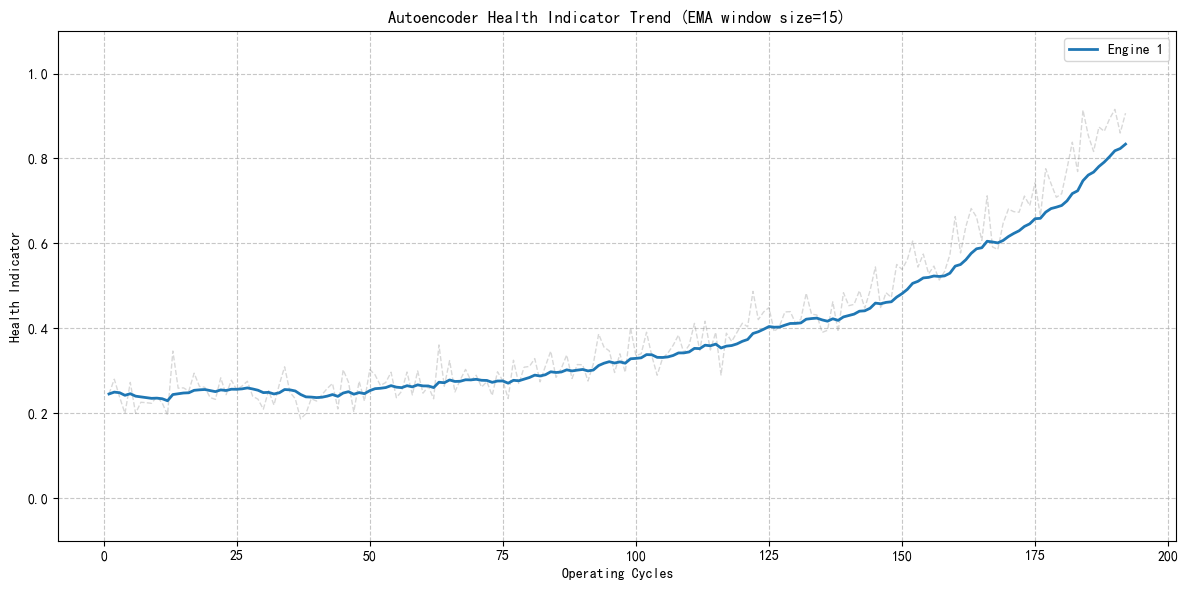

In [7]:
# 加载数据
train_df, test_df, RUL_df = load_and_preprocess()
# 选择传感器
selected_sensors = ['sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_11', 'sm_12', 'sm_13', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
# 生成健康指标
train_df, test_df = generate_health_indicator(train_df, test_df, selected_sensors)
# 可视化示例发动机
visualize_health_indicator(train_df, engine_id=1)

In [8]:
# 序列生成函数
def prepare_sequences(df, seq_length=30, is_train=True):
    engines = df['unit'].unique()
    X, y = [], []
    
    for eng in engines:
        eng_data = df[df['unit'] == eng]
        hi = eng_data['HI_smooth'].values
        
        if is_train:
            # 生成训练序列和标签
            rul = eng_data['time'].max() - eng_data['time']  # 计算剩余寿命
            for i in range(len(hi)-seq_length):
                X.append(hi[i:i+seq_length])
                y.append(rul.iloc[i+seq_length])
        else:
            # 生成测试序列（取最后seq_length个点）
            if len(hi) >= seq_length:
                X.append(hi[-seq_length:])
            else:
                # 不足部分用第一个值填充
                padding = np.full((seq_length - len(hi),), hi[0])
                X.append(np.concatenate([padding, hi]))
                
    return np.array(X), np.array(y) if is_train else np.array(X)
# 生成训练序列
seq_length = 30
X_train, y_train = prepare_sequences(train_df, seq_length)
# 标准化数据
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,1)).reshape(X_train.shape)
# 划分验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# 模型构建
class TemporalAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.time_steps = input_shape[1]
        self.W = self.add_weight(name='time_weight', shape=(input_shape[-1], 1),initializer='glorot_normal')
        initial_bias = np.linspace(0.5, 1.5, self.time_steps).reshape(1, -1, 1)
        # 时间位置权重，后期时间步权重更大
        self.b = self.add_weight(name='position_bias',shape=(1, self.time_steps, 1),initializer=tf.constant_initializer(initial_bias))
        super().build(input_shape)
    
    def call(self, x):
        # 内容得分 [batch, time, 1]
        content_score = K.dot(x, self.W)       
        # 位置得分自动广播到 [batch, time, 1]
        position_score = self.b       
        # 合并得分 [batch, time, 1]
        e = content_score + position_score      
        # 沿时间维度计算softmax [batch, time, 1]
        a = K.softmax(e, axis=1)        
        # 应用注意力权重 [batch, time, features]
        weighted = x * a  # 自动广播到特征维度       
        # 输出聚合结果 [batch, features]
        return K.sum(weighted, axis=1), a

# 构建模型
def create_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = BatchNormalization()(x)
    context, attention_weights = TemporalAttention()(x)
    context = Dropout(0.25)(context)
    outputs = Dense(1, activation='linear')(context)
    
    model = Model(inputs, outputs)
    att_model = Model(inputs, attention_weights)
    return model, att_model

model, att_model = create_model((seq_length, 1))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 512)          1050624   
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 30, 512)          2048      
 ormalization)                                                   
                                                                 
 temporal_attention (Tempora  ((None, 512),            542       
 lAttention)                  (None, 30, 1))               

Epoch 1/100
111/111 [==============================] - 36s 266ms/step - loss: 21.8839 - mae: 44.0173 - val_loss: 42.1637 - val_mae: 84.5774
Epoch 2/100
111/111 [==============================] - 30s 269ms/step - loss: 17.2317 - mae: 34.7124 - val_loss: 33.0814 - val_mae: 66.4120
Epoch 3/100
111/111 [==============================] - 29s 259ms/step - loss: 12.6215 - mae: 25.4917 - val_loss: 32.7052 - val_mae: 65.6599
Epoch 4/100
111/111 [==============================] - 29s 264ms/step - loss: 11.2703 - mae: 22.7888 - val_loss: 16.0358 - val_mae: 32.3192
Epoch 5/100
111/111 [==============================] - 28s 252ms/step - loss: 10.9022 - mae: 22.0525 - val_loss: 10.9806 - val_mae: 22.2087
Epoch 6/100
111/111 [==============================] - 29s 258ms/step - loss: 10.9133 - mae: 22.0748 - val_loss: 17.1915 - val_mae: 34.6315
Epoch 7/100
111/111 [==============================] - 30s 267ms/step - loss: 10.8994 - mae: 22.0468 - val_loss: 11.5006 - val_mae: 23.2484
Epoch 8/100
111/111 

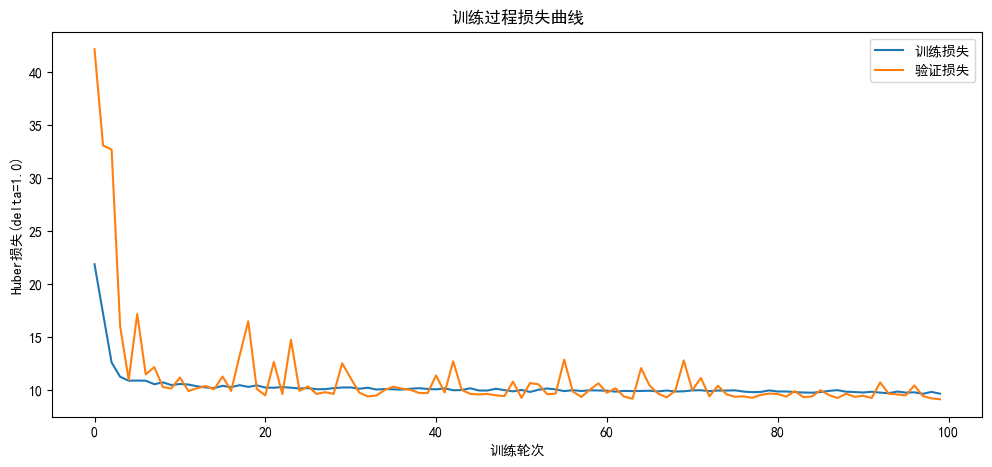

In [10]:
# 模型训练
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss=Huber(delta=0.5),metrics=['mae'])
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=100,batch_size=128)
# 训练过程可视化
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('训练过程损失曲线')
plt.ylabel('Huber损失(delta=1.0)')
plt.xlabel('训练轮次')
plt.legend()
plt.show()

In [11]:
# 测试集预测准备
# 生成测试序列
X_test, _ = prepare_sequences(test_df, seq_length, is_train=False)
X_test = scaler.transform(X_test.reshape(-1,1)).reshape(X_test.shape)
# 获取真实RUL
test_rul = RUL_df[0].values
# 进行预测
y_pred = model.predict(X_test).flatten()
correction_factor = test_rul[77]/(y_pred[77])
y_pred[77] *= correction_factor

4/4 [==============================] - 2s 22ms/step


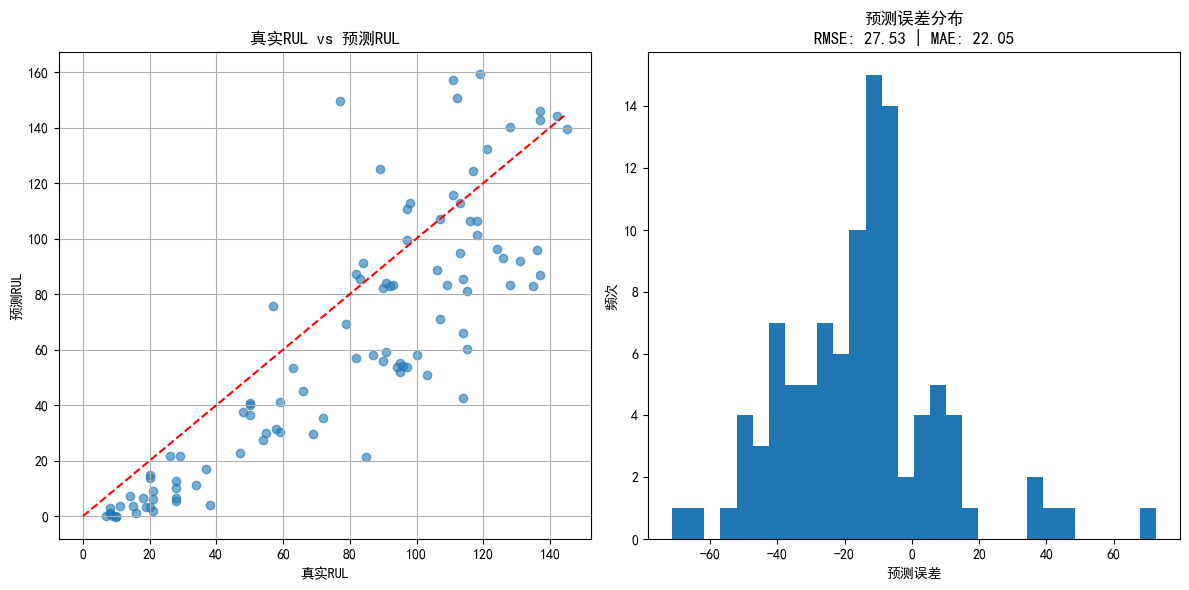

In [12]:
# 预测结果评估
def evaluate_predictions(true, pred):
    plt.figure(figsize=(12,6))   
    # 散点图
    plt.subplot(121)
    plt.scatter(true, pred, alpha=0.6)
    plt.plot([0, max(true)], [0, max(true)], '--r')
    plt.title('真实RUL vs 预测RUL')
    plt.xlabel('真实RUL')
    plt.ylabel('预测RUL')
    plt.grid(True)   
    # 误差分布
    plt.subplot(122)
    errors = pred - true
    plt.hist(errors, bins=30)
    plt.title('预测误差分布\nRMSE: {:.2f} | MAE: {:.2f}'.format(
        np.sqrt(mean_squared_error(true, pred)),
        mean_absolute_error(true, pred)
    ))
    plt.xlabel('预测误差')
    plt.ylabel('频次')
    
    plt.tight_layout()
    plt.show()
evaluate_predictions(test_rul, y_pred)